# Project 4:  Neural Network Lab
## Jack Weissenberger
### Part 1: Compare number of hidden layers to the accuracy of the network

In the first few cells, we are loading the mnist dataset

In [1]:
import os
import struct
import numpy as np
 
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, 
                               '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, 
                               '%s-images-idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', 
                                 lbpath.read(8))
        labels = np.fromfile(lbpath, 
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", 
                                               imgpath.read(16))
        images = np.fromfile(imgpath, 
                             dtype=np.uint8).reshape(len(labels), 784)
        images = ((images / 255.) - .5) * 2
 
    return images, labels

In [2]:
# unzips mnist

import sys
import gzip
import shutil

if (sys.version_info > (3, 0)):
    writemode = 'wb'
else:
    writemode = 'w'

zipped_mnist = [f for f in os.listdir('./') if f.endswith('ubyte.gz')]
for z in zipped_mnist:
    with gzip.GzipFile(z, mode='rb') as decompressed, open(z[:-3], writemode) as outfile:
        outfile.write(decompressed.read())

In [3]:
X_train, y_train = load_mnist('', kind='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

Rows: 60000, columns: 784


In [4]:
X_test, y_test = load_mnist('', kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 10000, columns: 784


In [5]:
import matplotlib.pyplot as plt

In [6]:
np.savez_compressed('mnist_scaled.npz', 
                    X_train=X_train,
                    y_train=y_train,
                    X_test=X_test,
                    y_test=y_test)

In [7]:
mnist = np.load('mnist_scaled.npz')
mnist.files

['y_test', 'y_train', 'X_test', 'X_train']

Here we are assigning the the split data set

In [8]:
X_train, y_train, X_test, y_test = [mnist[f] for f in ['X_train', 'y_train', 
                                    'X_test', 'y_test']]

del mnist

X_train.shape

(60000, 784)

In the cell below we define the methods we will need for the neural network

In [9]:
class NeuralNetMLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.

    Parameters
    ------------
    n_hidden : int (default: 30)
        Number of hidden units.
    l2 : float (default: 0.)
        Lambda value for L2-regularization.
        No regularization if l2=0. (default)
    epochs : int (default: 100)
        Number of passes over the training set.
    eta : float (default: 0.001)
        Learning rate.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent circles.
    minibatch_size : int (default: 1)
        Number of training samples per minibatch.
    seed : int (default: None)
        Random seed for initalizing weights and shuffling.

    Attributes
    -----------
    eval_ : dict
      Dictionary collecting the cost, training accuracy,
      and validation accuracy for each epoch during training.

    """
    def __init__(self, n_hidden=30,
                 l2=0., epochs=100, eta=0.001,
                 shuffle=True, minibatch_size=1, seed=None):

        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size

    def _onehot(self, y, n_classes):
        """Encode labels into one-hot representation

        Parameters
        ------------
        y : array, shape = [n_samples]
            Target values.

        Returns
        -----------
        onehot : array, shape = (n_samples, n_labels)

        """
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T

    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def _forward(self, X):
        """Compute forward propagation step"""

        # step 1: net input of hidden layer
        # [n_samples, n_features] dot [n_features, n_hidden]
        # -> [n_samples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h

        # step 2: activation of hidden layer
        a_h = self._sigmoid(z_h)

        # step 3: net input of output layer
        # [n_samples, n_hidden] dot [n_hidden, n_classlabels]
        # -> [n_samples, n_classlabels]

        z_out = np.dot(a_h, self.w_out) + self.b_out

        # step 4: activation output layer
        a_out = self._sigmoid(z_out)

        return z_h, a_h, z_out, a_out

    def _compute_cost(self, y_enc, output):
        """Compute cost function.

        Parameters
        ----------
        y_enc : array, shape = (n_samples, n_labels)
            one-hot encoded class labels.
        output : array, shape = [n_samples, n_output_units]
            Activation of the output layer (forward propagation)

        Returns
        ---------
        cost : float
            Regularized cost

        """
        L2_term = (self.l2 *
                   (np.sum(self.w_h ** 2.) +
                    np.sum(self.w_out ** 2.)))

        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2) + L2_term
        return cost

    def predict(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.

        Returns:
        ----------
        y_pred : array, shape = [n_samples]
            Predicted class labels.

        """
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred

    def fit(self, X_train, y_train, X_valid, y_valid):
        """ Learn weights from training data.

        Parameters
        -----------
        X_train : array, shape = [n_samples, n_features]
            Input layer with original features.
        y_train : array, shape = [n_samples]
            Target class labels.
        X_valid : array, shape = [n_samples, n_features]
            Sample features for validation during training
        y_valid : array, shape = [n_samples]
            Sample labels for validation during training

        Returns:
        ----------
        self

        """
        n_output = np.unique(y_train).shape[0]  # number of class labels
        n_features = X_train.shape[1]

        ########################
        # Weight initialization
        ########################

        # weights for input -> hidden
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                                      size=(n_features, self.n_hidden))

        # weights for hidden -> output
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
                                        size=(self.n_hidden, n_output))

        epoch_strlen = len(str(self.epochs))  # for progress formatting
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

        y_train_enc = self._onehot(y_train, n_output)

        # iterate over training epochs
        for i in range(self.epochs):

            # iterate over minibatches
            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0] - self.minibatch_size +
                                   1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]

                # forward propagation
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])

                ##################
                # Backpropagation
                ##################

                # [n_samples, n_classlabels]
                sigma_out = a_out - y_train_enc[batch_idx]

                # [n_samples, n_hidden]
                sigmoid_derivative_h = a_h * (1. - a_h)

                # [n_samples, n_classlabels] dot [n_classlabels, n_hidden]
                # -> [n_samples, n_hidden]
                sigma_h = (np.dot(sigma_out, self.w_out.T) *
                           sigmoid_derivative_h)

                # [n_features, n_samples] dot [n_samples, n_hidden]
                # -> [n_features, n_hidden]
                grad_w_h = np.dot(X_train[batch_idx].T, sigma_h)
                grad_b_h = np.sum(sigma_h, axis=0)

                # [n_hidden, n_samples] dot [n_samples, n_classlabels]
                # -> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h.T, sigma_out)
                grad_b_out = np.sum(sigma_out, axis=0)

                # Regularization and weight updates
                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h # bias is not regularized
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h

                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out  # bias is not regularized
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out

            #############
            # Evaluation
            #############

            # Evaluation after each epoch during training
            z_h, a_h, z_out, a_out = self._forward(X_train)
            
            cost = self._compute_cost(y_enc=y_train_enc,
                                      output=a_out)

            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)

            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) /
                         X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) /
                         X_valid.shape[0])

            sys.stderr.write('\r%0*d/%d | Cost: %.2f '
                             '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                             (epoch_strlen, i+1, self.epochs, cost,
                              train_acc*100, valid_acc*100))
            sys.stderr.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)

        return self

Next I define the number of epochs, and pre-allocate the vectors that I will store the accuracy data in 

In [24]:
n_epochs = 100
hidden = 20

In [25]:
acc = np.zeros((1,10))
numHidden = np.zeros((1,10))
i = 0;

Here I loop over the training, adding a new layer to the neural network each time

In [26]:
while (hidden <= 200):
    nn = NeuralNetMLP(n_hidden= hidden, 
                      l2=0.01, 
                      epochs=n_epochs, 
                      eta=0.0005,
                      minibatch_size=100, 
                      shuffle=True,
                      seed=1)

    nn.fit(X_train=X_train[:55000], 
           y_train=y_train[:55000],
           X_valid=X_train[55000:],
           y_valid=y_train[55000:])

    y_test_pred = nn.predict(X_test)
    acc[0,i] = (np.sum(y_test == y_test_pred).astype(np.float) / X_test.shape[0])
    numHidden[0,i] = hidden
    hidden += 20
    i +=1

100/100 | Cost: 6172.20 | Train/Valid Acc.: 98.92%/98.18%   

Next I plot the Test accuracy vs the number of hidden layers 

<function matplotlib.pyplot.show>

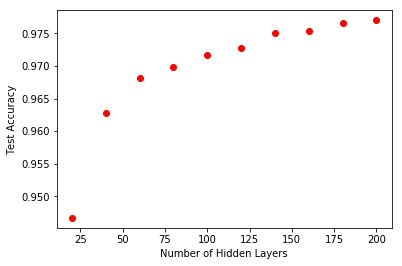

In [27]:
plt.plot(numHidden, acc, 'ro')
plt.ylabel("Test Accuracy")
plt.xlabel("Number of Hidden Layers")
plt.show

### Part 2: Using tensorflow to create a two layer neural network to classify mnist

In [28]:
import tensorflow as tf

Here I am importing mnist from tensorflow

In [29]:
from tensorflow.examples.tutorials.mnist import input_data

In [30]:
mnist = input_data.read_data_sets("/tmp/data/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Here I am doing the test train split

In [31]:
X_train = mnist.train.images
X_test = mnist.test.images
y_train = mnist.train.labels.astype("int")
y_test = mnist.test.labels.astype("int")

In [43]:
tf.reset_default_graph()

Here I am describing the shape of the neural network, there are 784 inputs because mnist is a 28 * 28 pixel image 

In [44]:
n_inputs = 784
n_hidden1 = 200
n_hidden2 = 100
n_outputs = 10

Placeholder nodes represent the training data and targets. The shapes of X and Y are only partialy defined because we do not know the batch size yet

In [45]:
X = tf.placeholder(tf.float32, shape = (None, n_inputs), name = "X")
y = tf.placeholder(tf.int64, shape = (None), name = "y")

Here we define each layer of the the network, notice that tanh is used for the activation function of the two hidden layers

In [46]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, name = "hidden1", 
                             activation = tf.nn.tanh)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name = "hidden2", 
                             activation = tf.nn.tanh)
    logits = tf.layers.dense(hidden2, n_outputs, name = "output")

Cross entropy is used to define the cost function of the network

In [47]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y,
                                                             logits = logits)
    loss = tf.reduce_mean(xentropy, name = "loss")

A gradient descent optimizer adjusts the weights

In [48]:
learningRate = 0.01

with tf.name_scope("train"):
    optimizer =  tf.train.GradientDescentOptimizer(learningRate)
    training_op = optimizer.minimize(loss)

Then we define accuracy as the measure we will use to evaluate the network

In [49]:
with tf.name_scope("evaluation"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

Node to initalize all the variables

In [50]:
init = tf.global_variables_initializer()

define number of epochs, batch size and preallocate space for train and test accuracy vectors and the vector that keeps track of the epochs

In [51]:
n_epochs = 100
batch_size = 50
trainAcc = np.zeros((1,100))
testAcc = np.zeros((1,100))
epochVec = np.zeros((1,100))

Next I train the network, filling up each of the accuracy vectors

In [52]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for i in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict= {X: X_batch, y: y_batch})
        trainAcc[0,epoch] = accuracy.eval(feed_dict= {X: X_batch, 
                                                      y: y_batch})
        testAcc[0, epoch] = accuracy.eval(feed_dict={X:mnist.test.images,
                                                    y: mnist.test.labels})
        epochVec[0, epoch] = epoch;
        
        if(epoch%5 == 0):
            print(epoch, "Train accuracy:", trainAcc[0,epoch],
                 "Test accuracy:", testAcc[0,epoch])

0 Train accuracy: 0.8799999952316284 Test accuracy: 0.8966000080108643
5 Train accuracy: 0.9200000166893005 Test accuracy: 0.9337000250816345
10 Train accuracy: 1.0 Test accuracy: 0.9477999806404114
15 Train accuracy: 0.9200000166893005 Test accuracy: 0.9557999968528748
20 Train accuracy: 0.9800000190734863 Test accuracy: 0.9613000154495239
25 Train accuracy: 0.9800000190734863 Test accuracy: 0.9649999737739563
30 Train accuracy: 0.9800000190734863 Test accuracy: 0.9670000076293945
35 Train accuracy: 0.9800000190734863 Test accuracy: 0.9689000248908997
40 Train accuracy: 1.0 Test accuracy: 0.9702000021934509
45 Train accuracy: 1.0 Test accuracy: 0.972100019454956
50 Train accuracy: 0.9800000190734863 Test accuracy: 0.9728000164031982
55 Train accuracy: 0.9800000190734863 Test accuracy: 0.9739999771118164
60 Train accuracy: 1.0 Test accuracy: 0.9749000072479248
65 Train accuracy: 1.0 Test accuracy: 0.975600004196167
70 Train accuracy: 1.0 Test accuracy: 0.9763000011444092
75 Train accur

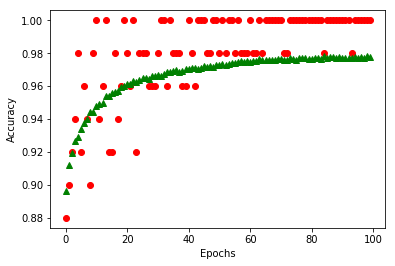

In [53]:
plt.plot(epochVec, trainAcc, 'ro')
plt.plot(epochVec, testAcc, 'g^')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

LEGEND: Red dots are the training accuracy, Green triangles are the test accuracy

This is the plot of train and test accuracy vs the epoch